In [1]:
# Import Dependencies
from __future__ import absolute_import, division, print_function
import random
import pathlib

import numpy as np
import tensorflow as tf
import IPython.display as display

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.layers import BatchNormalization
from tensorflow.keras.layers import (Dense, Activation,
                                     Dropout, Flatten,
                                     Conv2D, MaxPooling2D)

tf.enable_eager_execution()

In [2]:
tf.__version__

'1.13.1'

In [4]:
class AlexNet():
    
    def __init__(self, num_classes=None):
        
        if num_classes is None:
            self.NUM_CLASSES = 1000
        else:
            self.NUM_CLASSES = num_classes
        
        self.model = Sequential()
        build(self)
    
    def build(self):
        # 1st Convolutional Layer
        self.model.add(Conv2D(filters=96, input_shape=(224,224,3), kernel_size=(11,11),
                         strides=(4,4), padding='valid'))
        self.model.add(Activation('relu'))
        # Pooling 
        self.model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
        # Batch Normalisation before passing it to the next layer
        self.model.add(BatchNormalization())

        # 2nd Convolutional Layer
        self.model.add(Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), padding='valid'))
        self.model.add(Activation('relu'))
        # Pooling
        self.model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
        # Batch Normalisation
        self.model.add(BatchNormalization())

        # 3rd Convolutional Layer
        self.model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid'))
        self.model.add(Activation('relu'))
        # Batch Normalisation
        self.model.add(BatchNormalization())

        # 4th Convolutional Layer
        self.model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid'))
        self.model.add(Activation('relu'))
        # Batch Normalisation
        self.model.add(BatchNormalization())

        # 5th Convolutional Layer
        self.model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='valid'))
        self.model.add(Activation('relu'))
        # Pooling
        self.model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
        # Batch Normalisation
        self.model.add(BatchNormalization())

        # Passing it to a dense layer
        self.model.add(Flatten())
        # 1st Dense Layer
        self.model.add(Dense(9216, input_shape=(224*224*3,)))
        self.model.add(Activation('relu'))
        # Add Dropout to prevent overfitting
        self.model.add(Dropout(0.4))
        # Batch Normalisation
        self.model.add(BatchNormalization())

        # 2nd Dense Layer
        self.model.add(Dense(4096))
        self.model.add(Activation('relu'))
        # Add Dropout
        self.model.add(Dropout(0.4))
        # Batch Normalisation
        self.model.add(BatchNormalization())

        # 3rd Dense Layer
        self.model.add(Dense(4096))
        self.model.add(Activation('relu'))
        # Add Dropout
        self.model.add(Dropout(0.4))
        # Batch Normalisation
        self.model.add(BatchNormalization())

        # Output Layer
        self.model.add(Dense(self.NUM_CLASSES))
        self.model.add(Activation('softmax'))

In [5]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [6]:
# Download Flower Dataset
data_root = tf.keras.utils.get_file('flower_photos','https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz', untar=True)
data_root = pathlib.Path(data_root)
print(data_root)

/home/maksym/.keras/datasets/flower_photos


In [7]:
# View part of data in directory
for item in data_root.iterdir():
  print(item)

/home/maksym/.keras/datasets/flower_photos/daisy
/home/maksym/.keras/datasets/flower_photos/dandelion
/home/maksym/.keras/datasets/flower_photos/LICENSE.txt
/home/maksym/.keras/datasets/flower_photos/tulips
/home/maksym/.keras/datasets/flower_photos/sunflowers
/home/maksym/.keras/datasets/flower_photos/roses


In [8]:
# Join all image path in one array
all_image_paths = list(data_root.glob('*/*'))
all_image_paths = [str(path) for path in all_image_paths]
random.shuffle(all_image_paths)

image_count = len(all_image_paths)
image_count

3670

In [9]:
# View first 10`n images pathes
all_image_paths[:10]

['/home/maksym/.keras/datasets/flower_photos/sunflowers/6606823367_e89dc52a95_n.jpg',
 '/home/maksym/.keras/datasets/flower_photos/daisy/9242705328_eee8402a8d.jpg',
 '/home/maksym/.keras/datasets/flower_photos/daisy/3506866918_61dd5fc53b_n.jpg',
 '/home/maksym/.keras/datasets/flower_photos/dandelion/8717161615_4c1e403083.jpg',
 '/home/maksym/.keras/datasets/flower_photos/roses/16258946661_f9739cdc0a.jpg',
 '/home/maksym/.keras/datasets/flower_photos/tulips/113902743_8f537f769b_n.jpg',
 '/home/maksym/.keras/datasets/flower_photos/tulips/12916135413_dafcf3089e_n.jpg',
 '/home/maksym/.keras/datasets/flower_photos/tulips/8712266605_3787e346cd_n.jpg',
 '/home/maksym/.keras/datasets/flower_photos/sunflowers/20156280765_a6baea3176.jpg',
 '/home/maksym/.keras/datasets/flower_photos/tulips/8454719295_4276c0e9c5_n.jpg']

In [10]:
# Read attr`s in License file line by line and split for 'CC-BY'
attributions = (data_root/"LICENSE.txt").read_text(encoding="utf8").splitlines()[4:]
attributions = [line.split(' CC-BY') for line in attributions]
attributions = dict(attributions)
len(attributions)

3670

In [15]:
# Create a caption of image for image_path
def caption_image(image_path):
    image_rel = pathlib.Path(image_path).relative_to(data_root)
    return "Image (CC BY 2.0) " + ' - '.join(attributions[str(image_rel)].split(' - ')[:-1])

In [16]:
# Get label names from dir names by classes
label_names = sorted(item.name for item in data_root.glob('*/') if item.is_dir())
label_names

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

In [17]:
# From label_names create dict where each label have id
label_to_index = dict((name, index) for index, name  in enumerate(label_names))
label_to_index

{'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}

In [18]:
# Create array with image labels. Label for id

all_image_labels = [label_to_index[pathlib.Path(path).parent.name]
                    for path in all_image_paths]

print("First 10 labels in indices: ", all_image_labels[:10])

First 10 labels in indices:  [3, 0, 0, 1, 2, 4, 4, 4, 3, 4]


In [19]:
# Create a function to prepare image for training. Decode -> Resize -> Normalize ([0, 255]->[0, 1])
# Load image with tf.read_file

def preprocess_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize_images(image, [224, 224])
    image /= 255.0
    
    return image

def load_and_preprocess_image(path):
    image = tf.read_file(path)
    return preprocess_image(image)

Text(0.5, 1.0, 'Image (CC BY 2.0)  by Matt Buck')

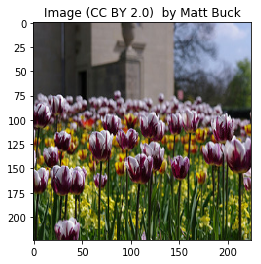

In [26]:
# Show some image to see what we have.
%matplotlib inline
import matplotlib.pyplot as plt

image_path = all_image_paths[10]

plt.imshow(load_and_preprocess_image(image_path))
plt.title(caption_image(image_path))

In [29]:
# Start to build paths dataset with tf Dataset function.
# Create Tensors Dataset 
path_ds = tf.data.Dataset.from_tensor_slices(all_image_paths)
print(type(path_ds))

<class 'tensorflow.python.data.ops.dataset_ops.DatasetV1Adapter'>


In [30]:
# Load images to image dataset. Mapping path ds apply load_and_preprocess_image, num_parallel calls is autotune
image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)

Instructions for updating:
Colocations handled automatically by placer.


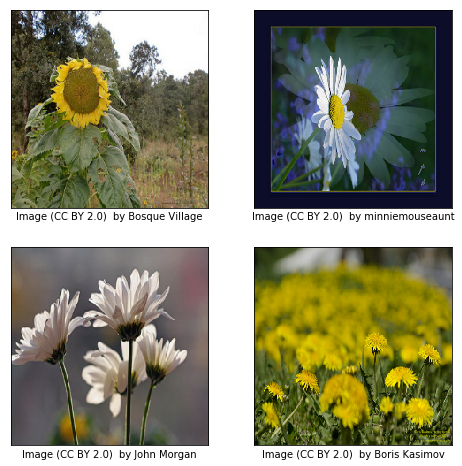

In [31]:
# Show first 4 image from image_ds with captions

%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(8,8))
for n, image in enumerate(image_ds.take(4)):
    plt.subplot(2,2,n+1)
    plt.imshow(image)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(caption_image(all_image_paths[n]))

In [32]:
# Start to build labels dataset with tf Dataset function.
# Create Tensors Dataset 
label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(all_image_labels, tf.int64)) # format tensor to a new dtype

In [33]:
# Show first 4 labels native
for label in label_ds.take(4):
    print(label)

tf.Tensor(3, shape=(), dtype=int64)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)


In [34]:
# Show first 4 labels prepared
for label in label_ds.take(10):
    print(label_names[label.numpy()])

sunflowers
daisy
daisy
dandelion
roses
tulips
tulips
tulips
sunflowers
tulips


In [35]:
# Zipping dataset to pair {'image', 'label'}
image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))

In [36]:
# Show params current ds
print('image shape: ', image_label_ds.output_shapes[0])
print('label shape: ', image_label_ds.output_shapes[1])
print('types: ', image_label_ds.output_types)
print()
print(image_label_ds)

image shape:  (224, 224, 3)
label shape:  ()
types:  (tf.float32, tf.int64)

<DatasetV1Adapter shapes: ((224, 224, 3), ()), types: (tf.float32, tf.int64)>


In [37]:
# Alternative way to form ds
ds = tf.data.Dataset.from_tensor_slices((all_image_paths, all_image_labels))

def load_and_preprocess_from_path_label(path, label):
    return load_and_preprocess_image(path), label

image_label_ds_v2 = ds.map(load_and_preprocess_from_path_label)
image_label_ds_v2

<DatasetV1Adapter shapes: ((224, 224, 3), ()), types: (tf.float32, tf.int32)>

In [40]:
BATCH_SIZE = 32
ds = image_label_ds.shuffle(buffer_size=image_count)
ds = ds.repeat()
ds = ds.batch(BATCH_SIZE)
ds = ds.prefetch(buffer_size=AUTOTUNE)
ds

<DatasetV1Adapter shapes: ((?, 224, 224, 3), (?,)), types: (tf.float32, tf.int64)>